In [1]:
import math
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from read_data import read_json
from scipy import stats

In [2]:
# path = "../outputs/instances"
path = "../outputs/instances_with_tb_sa"


In [3]:
instances = os.listdir(path)
instances.sort(key=lambda x: int("".join(filter(str.isdigit, x))))
instances

['2025_05_10_11_16_23_had12',
 '2025_05_10_11_16_24_rou15',
 '2025_05_10_11_16_26_esc16a',
 '2025_05_10_11_16_27_kra30a',
 '2025_05_10_11_16_57_ste36c',
 '2025_05_10_11_17_41_tai40b',
 '2025_05_10_11_19_17_sko81',
 '2025_05_10_11_40_45_lipa90b']

In [4]:
instances_data = {}

for instance in instances:
    instance_path = os.path.join(path, instance)
    instance_data = read_json(instance_path)
    insta_name = instance.split("_")[-1]
    
    keys = list(instance_data.keys())

    for key in keys:
        new_key = key
        if 'tabu' in key:
            new_key = "tabu_search"
        elif 'simluated_annealing' in key:
            new_key = "simluated_annealing"

        if new_key != key:
            instance_data[new_key] = instance_data[key]
            del instance_data[key]

    instances_data[insta_name] = instance_data

instances = list(map(lambda x: x.split("_")[-1], instances))
instances_data.keys()

dict_keys(['had12', 'rou15', 'esc16a', 'kra30a', 'ste36c', 'tai40b', 'sko81', 'lipa90b'])

In [5]:
algos = [a for a, _ in instances_data[instances[0]].items()]
algos

['greedy_construction_heuristic',
 'random_search',
 'random_start_greedy_local_search',
 'random_start_steepest_local_search',
 'random_walk',
 'simluated_annealing',
 'tabu_search']

## Quality

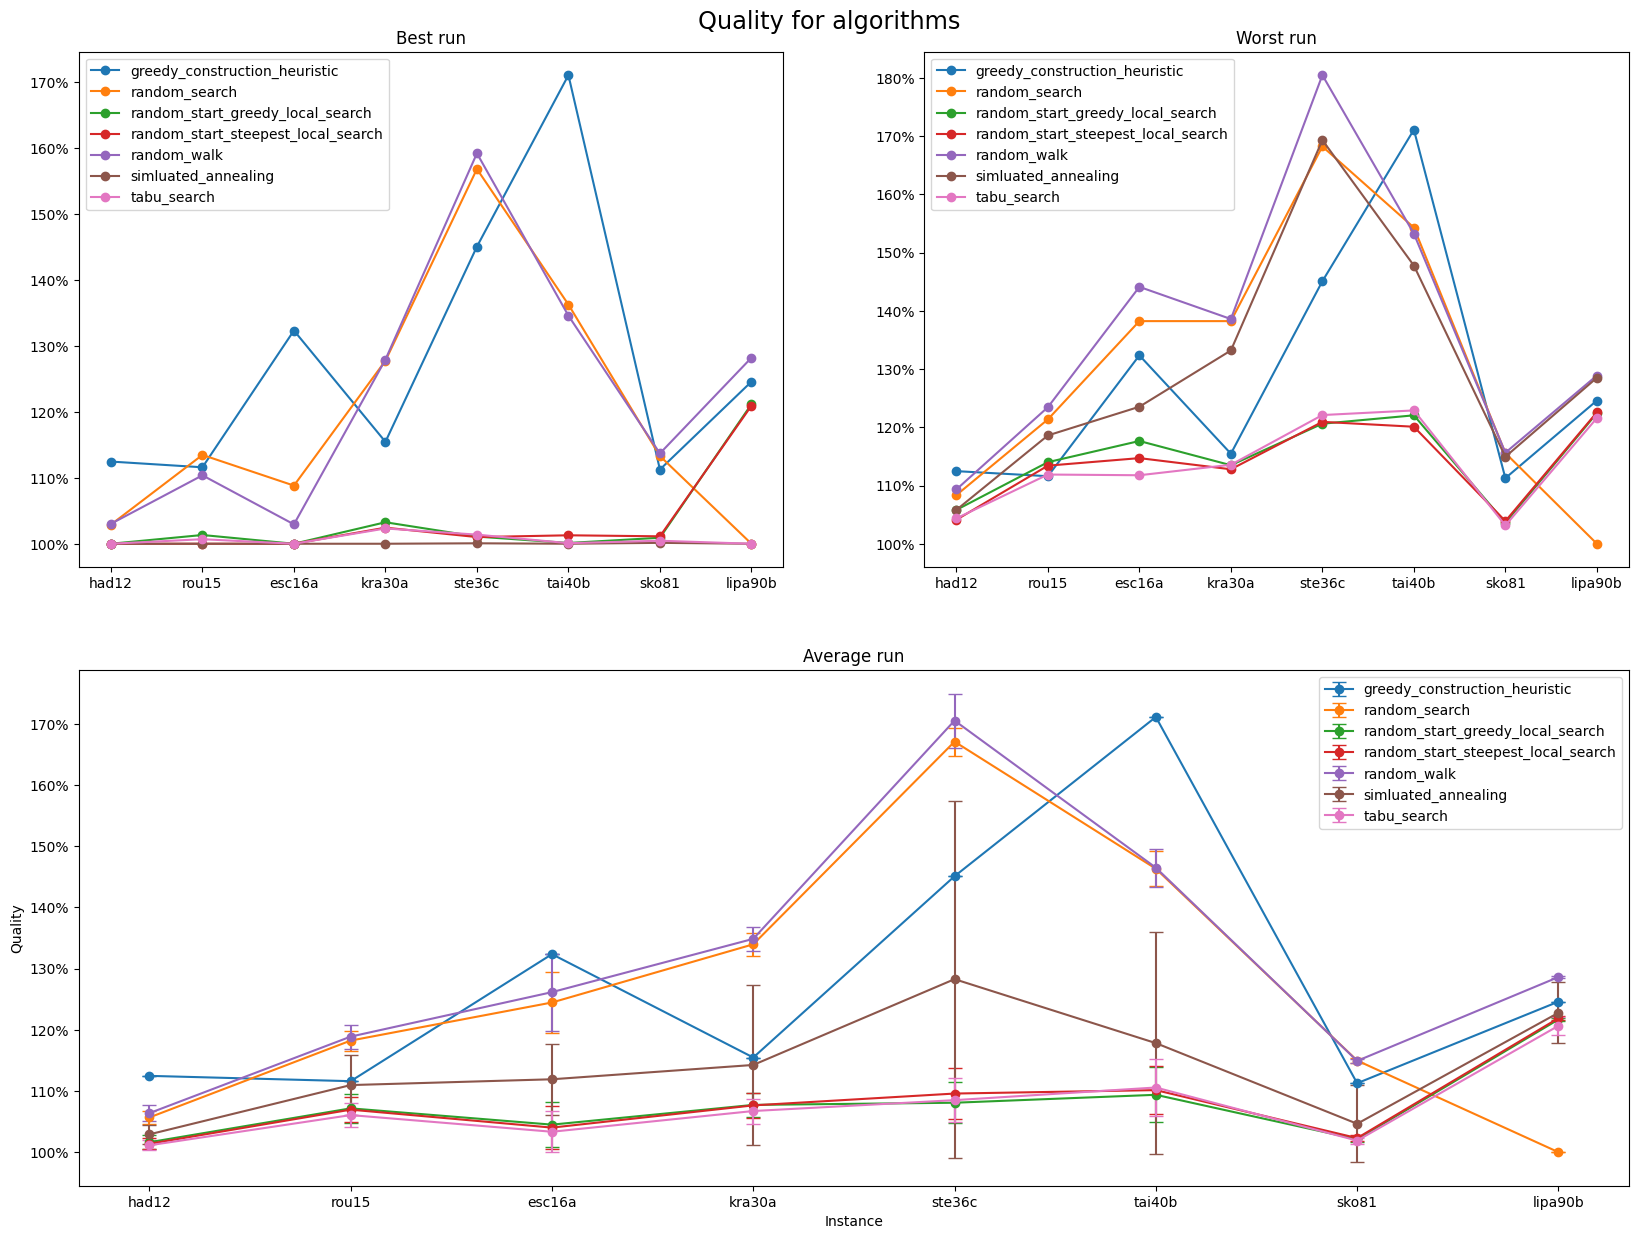

In [6]:
def plot_quality_per_instance(plots_n, subplot_index, get_final_score, title):
    ax = fig.add_subplot(math.ceil(plots_n / 2), 2, subplot_index)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.0f}%"))

    for algo in algos:
        data = [get_final_score(instances_data[i][algo]) / instances_data[i][algo].optimum * 100 for i in instances]
        ax.plot(instances, data, label=algo, marker="o")
        ax.set_title(title)
        ax.legend()

fig = plt.figure( figsize=(20, 14) )
st = fig.suptitle("Quality for algorithms", fontsize="xx-large")

plot_quality_per_instance(3, 1, lambda x: x.best_run.final_score, "Best run")

plot_quality_per_instance(3, 2, lambda x: x.worst_run.final_score, "Worst run")

ax = fig.add_subplot(2, 1, 2)

for algo in algos:
    dirty_data = [[r.final_score / instances_data[i][algo].optimum * 100 for r in instances_data[i][algo].runs] for i in instances]
    data = [np.mean(dd) for dd in dirty_data]
    std = [np.std(dd) for dd in dirty_data]
    ax.errorbar(instances, data, yerr=std, label=algo, marker="o", capsize=5)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.0f}%"))
    ax.set_title("Average run")
    ax.set_xlabel("Instance")
    ax.set_ylabel("Quality")
    ax.legend()

st.set_y(0.95)
fig.subplots_adjust(top=0.92)

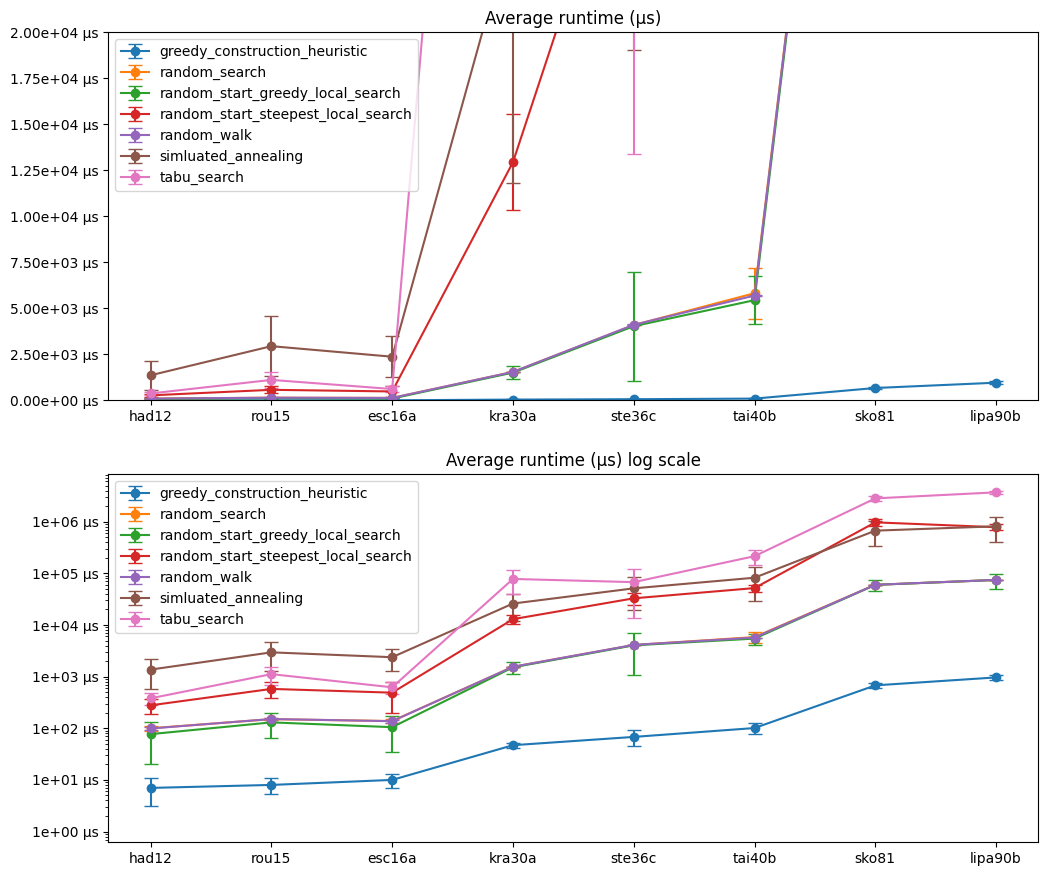

In [7]:
fig = plt.figure(figsize=(12, 10))

ax_norm = fig.add_subplot(2, 1, 1)
ax_log = fig.add_subplot(2, 1, 2)

for algo in algos:
    data = [instances_data[i][algo].avg_runtime for i in instances]
    data_std = [np.std([r.algorithm_run_time for r in instances_data[i][algo].runs]) for i in instances]
    ax_norm.errorbar(instances, data, yerr=data_std, label=algo, marker="o", capsize=5)
    ax_norm.set_title("Average runtime (μs)")
    ax_norm.legend()
    ax_norm.set_ylim(0, 20000)
    ax_norm.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2e μs"))


    # ax_log.plot(instances, data, label=algo, marker="o")
    ax_log.errorbar(instances, data, yerr=data_std, label=algo, marker="o", capsize=5)
    ax_log.set_title("Average runtime (μs) log scale")
    ax_log.set_yscale("log")
    ax_log.legend()
    ax_log.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.0e μs"))


fig.subplots_adjust(top=0.92)

## Effciency of algoirthm

In [8]:
have_free_time = False

if have_free_time:
    fig = plt.figure( figsize=(20, 20) )
    st = fig.suptitle("Effcieny of algorithms", fontsize="xx-large")
    
    algos_count = len(algos)
    
    for i, algo in enumerate(algos):
        ax = fig.add_subplot(math.ceil(algos_count / 2), 2, i + 1)
        do_the_line = False
    
        for instance in instances:
    
            algo_data = instances_data[instance][algo]
    
            y = []
    
            for step in range(max([r.iterations for r in algo_data.runs])):
                step_scores = [r.scores[step] for r in algo_data.runs if r.iterations > step]
                y.append(np.mean(step_scores) / algo_data.optimum)
    
            y = np.array(y) * 100
    
            if len(y) > 1:
                x = np.linspace(0, 1, len(y))    
                ax.plot(x, y, label=instance)
                do_the_line = True
            else:
                ax.plot([1], y, label=instance, marker="o")
    
    
        if do_the_line:
            ax.plot([0, 1], [100, 100], label="Optimum")
        else:
            ax.plot([1], [100], label="Optimum", marker="o")
    
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.0f}%"))
        ax.set_title(algo)
        ax.legend()
        ax.set_ylabel("Quality")
        ax.set_xlabel("Unified time scale")
    
    st.set_y(0.95)
    fig.subplots_adjust(top=0.93)

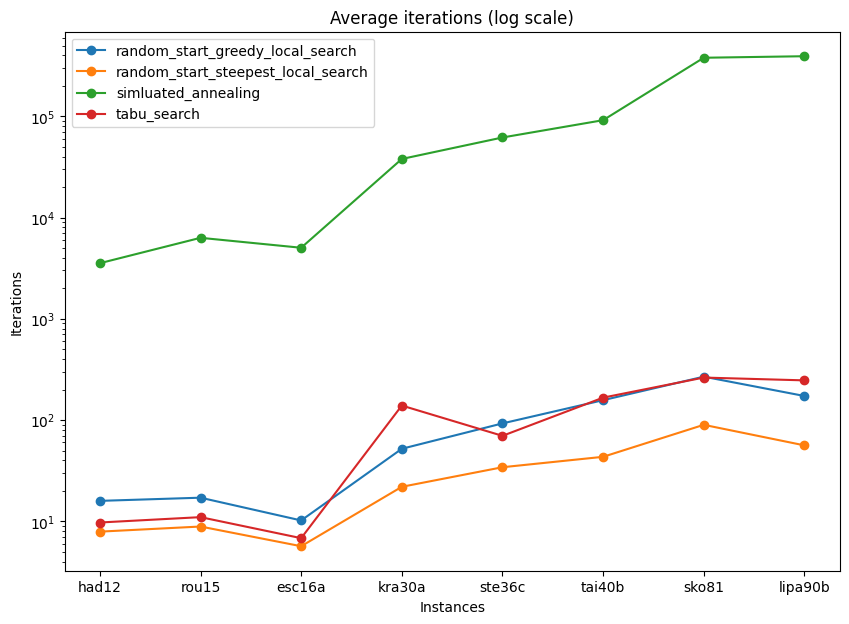

In [8]:
iterations = []
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(1, 1, 1)

for algo in algos:
    
    if "local_search" not  in algo and "tabu" not  in algo and "annealing" not  in algo: continue
    
    data = [np.mean([r.iterations for r in instances_data[i][algo].runs]) for i in instances]
    ax.plot(instances, data, label=algo, marker="o")
    ax.set_title("Average iterations (log scale)")
    ax.set_ylabel("Iterations")
    ax.set_xlabel("Instances")
    ax.set_yscale("log")
    ax.legend()
    

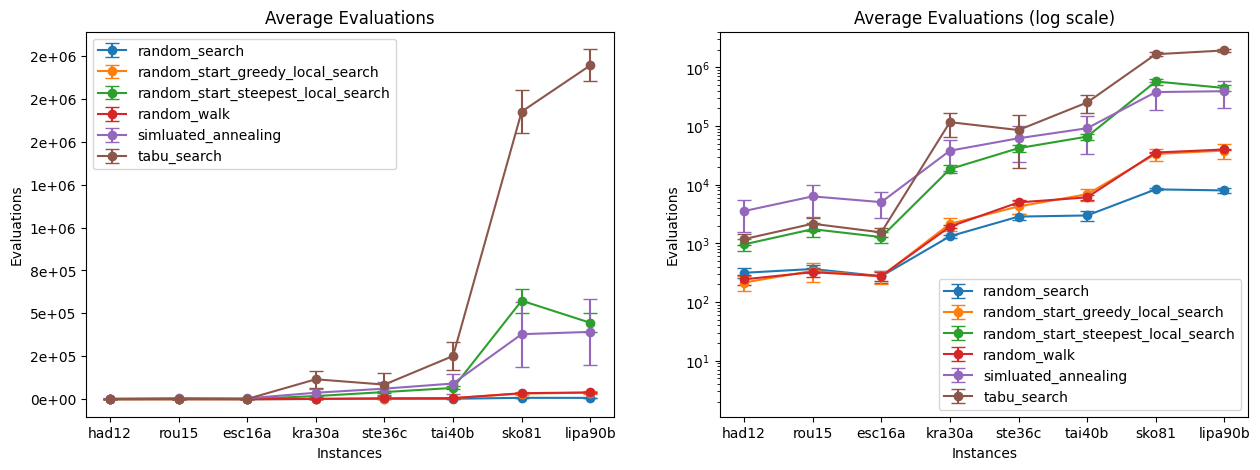

In [10]:
iterations = []
fig = plt.figure(figsize=(15, 5))

# ax_partial = fig.add_subplot(2, 2, 1)
# ax_partial_l = fig.add_subplot(2, 2, 2)
ax_full = fig.add_subplot(1, 2, 1)
ax_full_l = fig.add_subplot(1, 2, 2)


for algo in algos:
    
    if "heuristic" in algo: continue
    
    dirty_data_full = [[r.evaluations for r in instances_data[i][algo].runs] for i in instances]

    data_full = [np.mean(dd) for dd in dirty_data_full]

    # std_partial = [np.std(dd) for dd in dirty_data_partial]
    std_full = [np.std(dd) for dd in dirty_data_full]

    ax_full.errorbar(instances, data_full, yerr=std_full, capsize=5, marker="o", label=algo)
    ax_full.set_title("Average Evaluations")
    ax_full.set_ylabel("Evaluations")
    ax_full.set_xlabel("Instances")
    ax_full.legend()
    ax_full.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.0e"))

    ax_full_l.errorbar(instances, data_full, yerr=std_full, capsize=5, marker="o", label=algo)
    ax_full_l.set_title("Average Evaluations (log scale)")
    ax_full_l.set_ylabel("Evaluations")
    ax_full_l.set_xlabel("Instances")
    ax_full_l.set_yscale("log")
    ax_full_l.legend()


# RIP :(

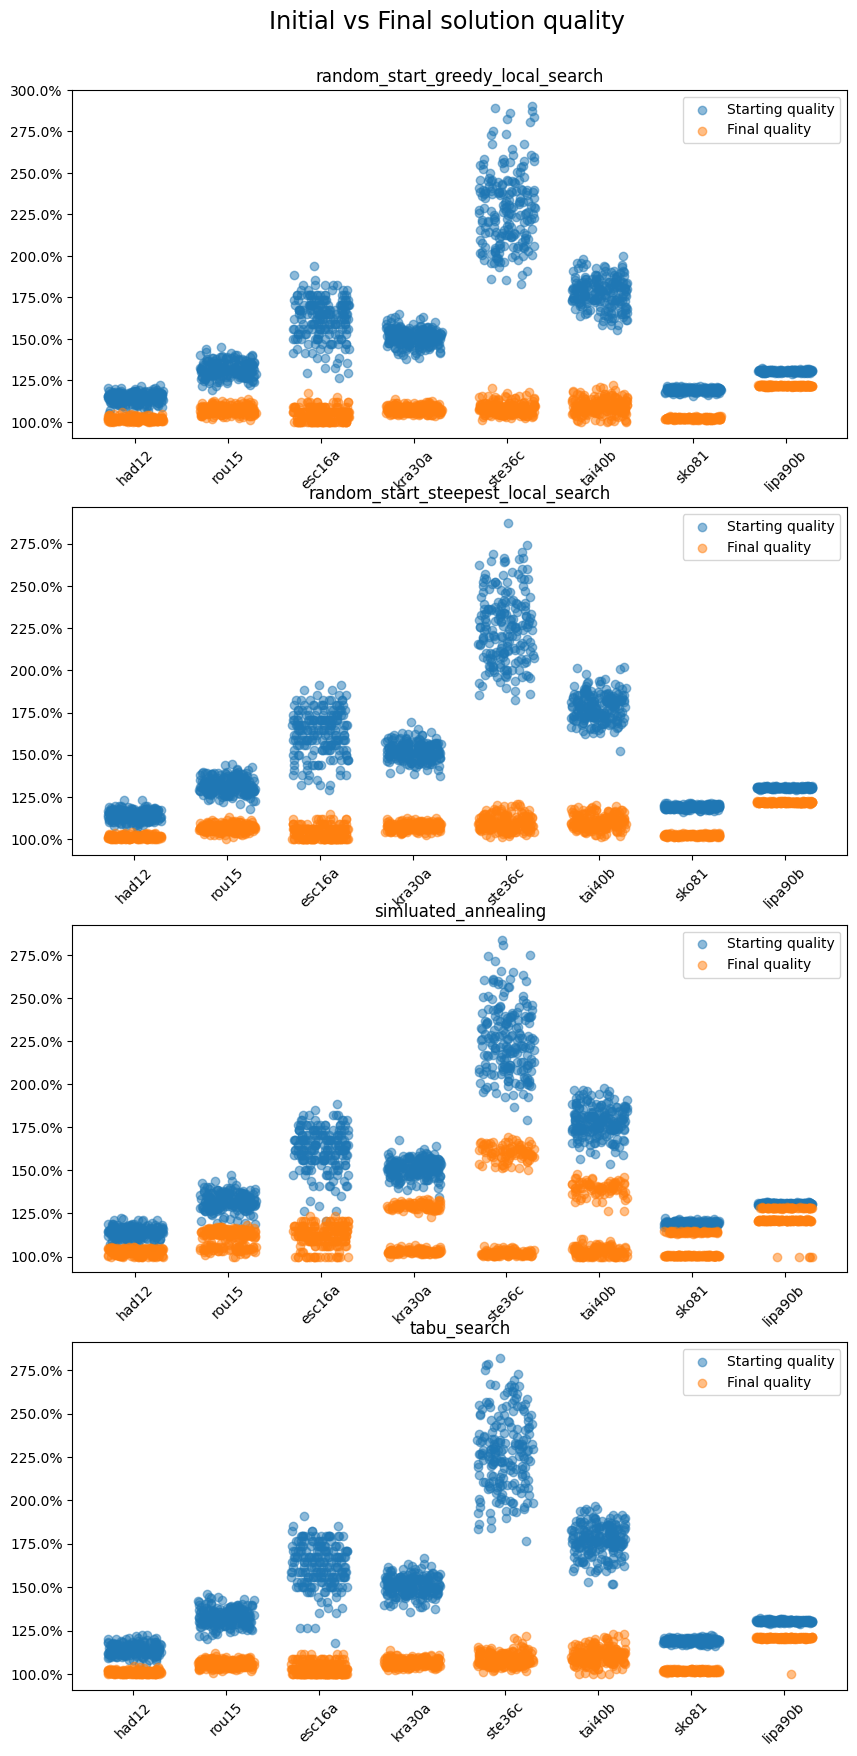

In [13]:
fig = plt.figure(figsize=(10, 20))
st = fig.suptitle("Initial vs Final solution quality", fontsize="xx-large")

# Create a mapping from instance names to numeric x-axis positions
instance_to_x = {inst: i for i, inst in enumerate(instances)}

for j, algo in enumerate(filter(lambda x: "local_search"  in x or "tabu"  in x or "annealing"  in x, algos)):
    starting_quality = []
    final_quality = []
    x_jittered = []

    ax = fig.add_subplot(4, 1, j + 1)

    for instance in instances:

        algo_data = instances_data[instance][algo]
        
        instance_starting_quality = [r.scores[0] / algo_data.optimum * 100 for r in algo_data.runs]
        instance_final_quality = [r.final_score / algo_data.optimum * 100 for r in algo_data.runs]
        
        # Base x position for this instance
        base_x = instance_to_x[instance]
        jitter_strength = 0.3
        n = len(instance_starting_quality)
        
        # Jittered x positions
        jittered_x = base_x + np.random.uniform(-jitter_strength, jitter_strength, size=n)

        starting_quality.extend(instance_starting_quality)
        final_quality.extend(instance_final_quality)
        x_jittered.extend(jittered_x)

    ax.scatter(x_jittered, starting_quality, label="Starting quality", marker="o", alpha=0.5)
    ax.scatter(x_jittered, final_quality, label="Final quality", marker="o", alpha=0.5)
        
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.1f}%"))

    # Set x-axis to categorical labels
    ax.set_xticks(list(instance_to_x.values()))
    ax.set_xticklabels(list(instance_to_x.keys()), rotation=45)
    ax.set_title(algo)
    ax.legend()

st.set_y(0.95)
fig.subplots_adjust(top=0.91)

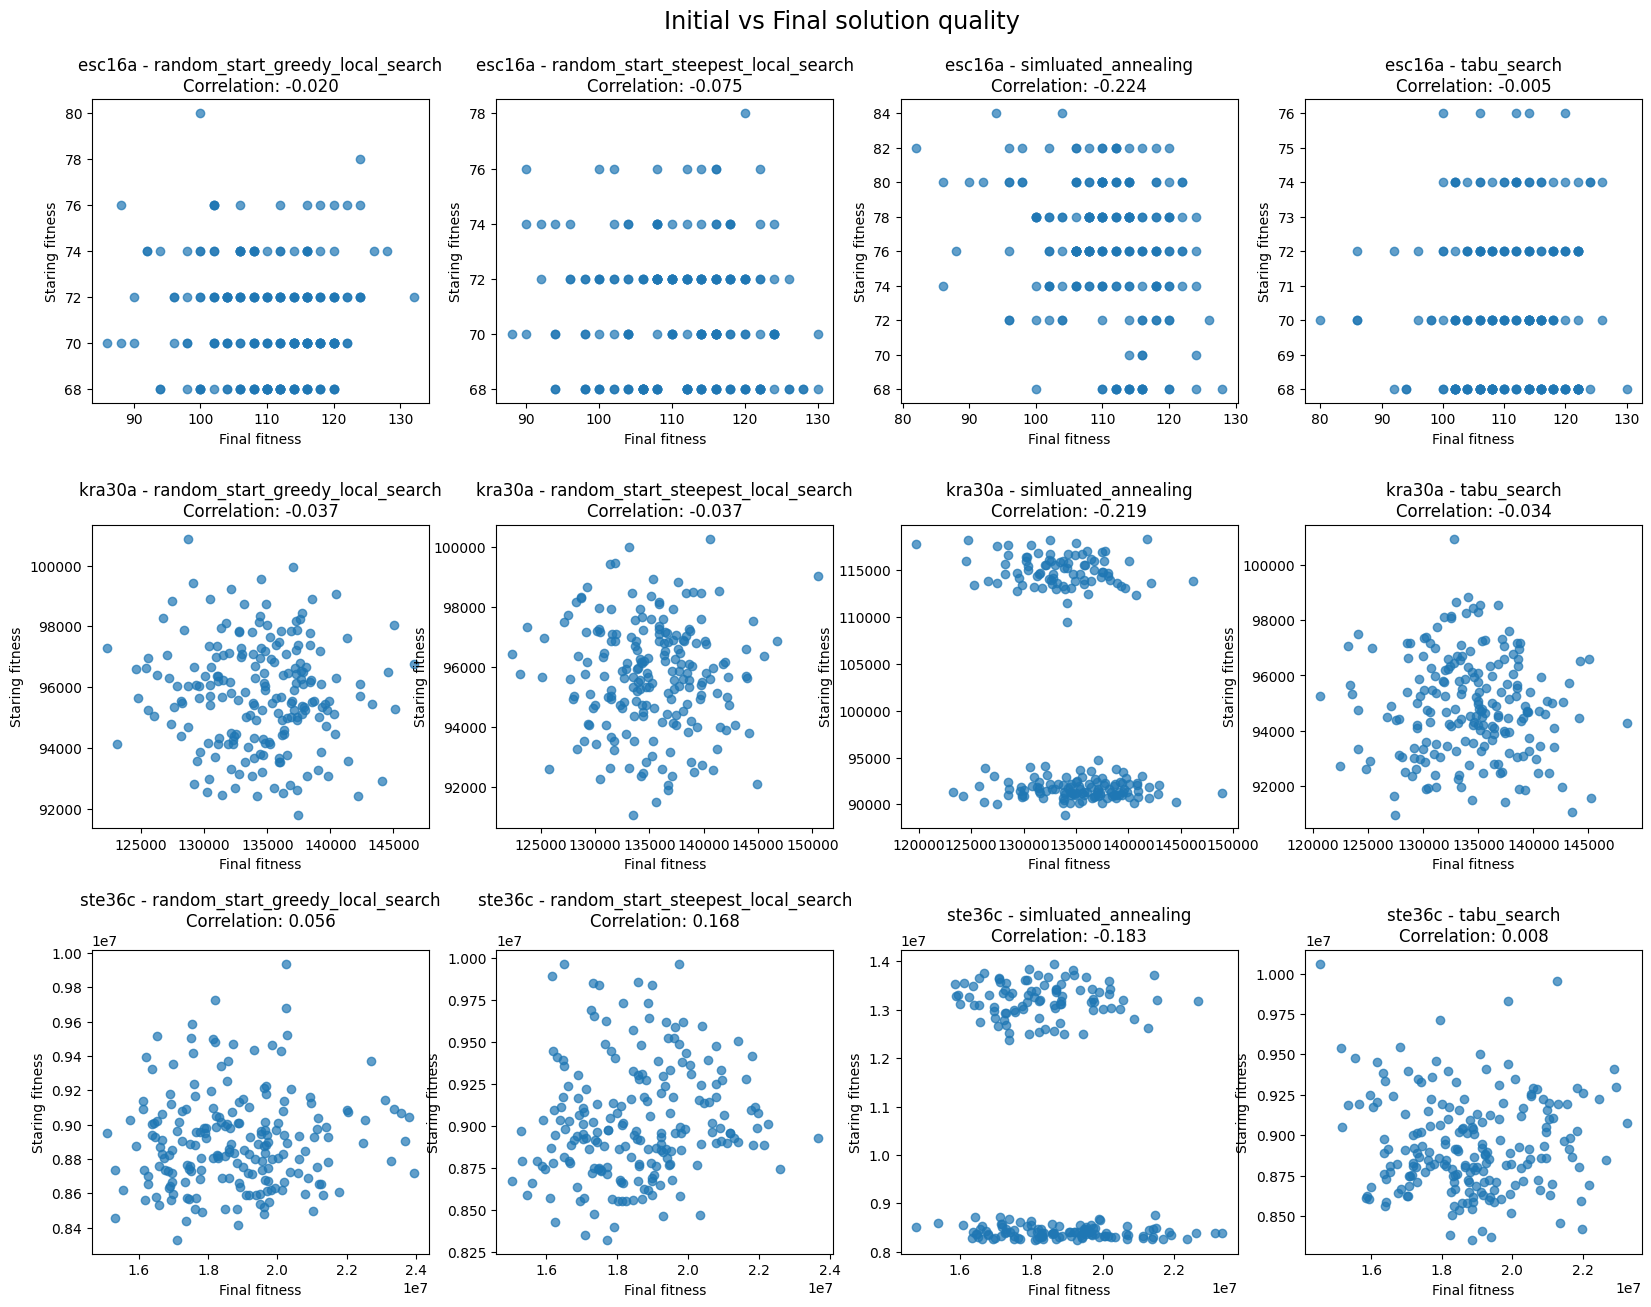

In [ ]:
instances_input = instances[2:5]

fig = plt.figure(figsize=(20, len(instances_input) * 10))
fig.subplots_adjust(hspace=0.3)
st = fig.suptitle("Initial vs Final solution quality", fontsize="xx-large")

for i, instance in enumerate(instances_input):

    for j, algo in enumerate(filter(lambda x: "local_search"  in x or "tabu"  in x or "annealing"  in x, algos)):
        ax = fig.add_subplot(len(instances_input) * 2, 4, i * 4 + j + 1)

        x = []
        y = []

        for run in instances_data[instance][algo].runs:
            x.append(run.scores[0])
            y.append(run.final_score)

        val_min = np.min([np.min(y), np.min(x)])
        val_max = np.max([np.max(y), np.max(x)])

        cor = stats.spearmanr(x, y)

        # ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.1f}%"))
        ax.set_title(f"{instance} - {algo}\nCorrelation: {cor.correlation:.3f}")
        ax.set_ylabel("Staring fitness")
        ax.set_xlabel("Final fitness")
        # rotate y labels
        


        # x = np.arange(0, len(y_avg_buffer) * 2, 2)

        ax.scatter(x, y, alpha=0.7)
        # ax.plot([val_min, val_max], [val_min, val_max], "--", label="No improvement line", color="orange")
        # ax.plot(x, y_min, label="Min")
        # ax.legend()

st.set_y(0.95)

fig.subplots_adjust(top=0.92, hspace=0.4)

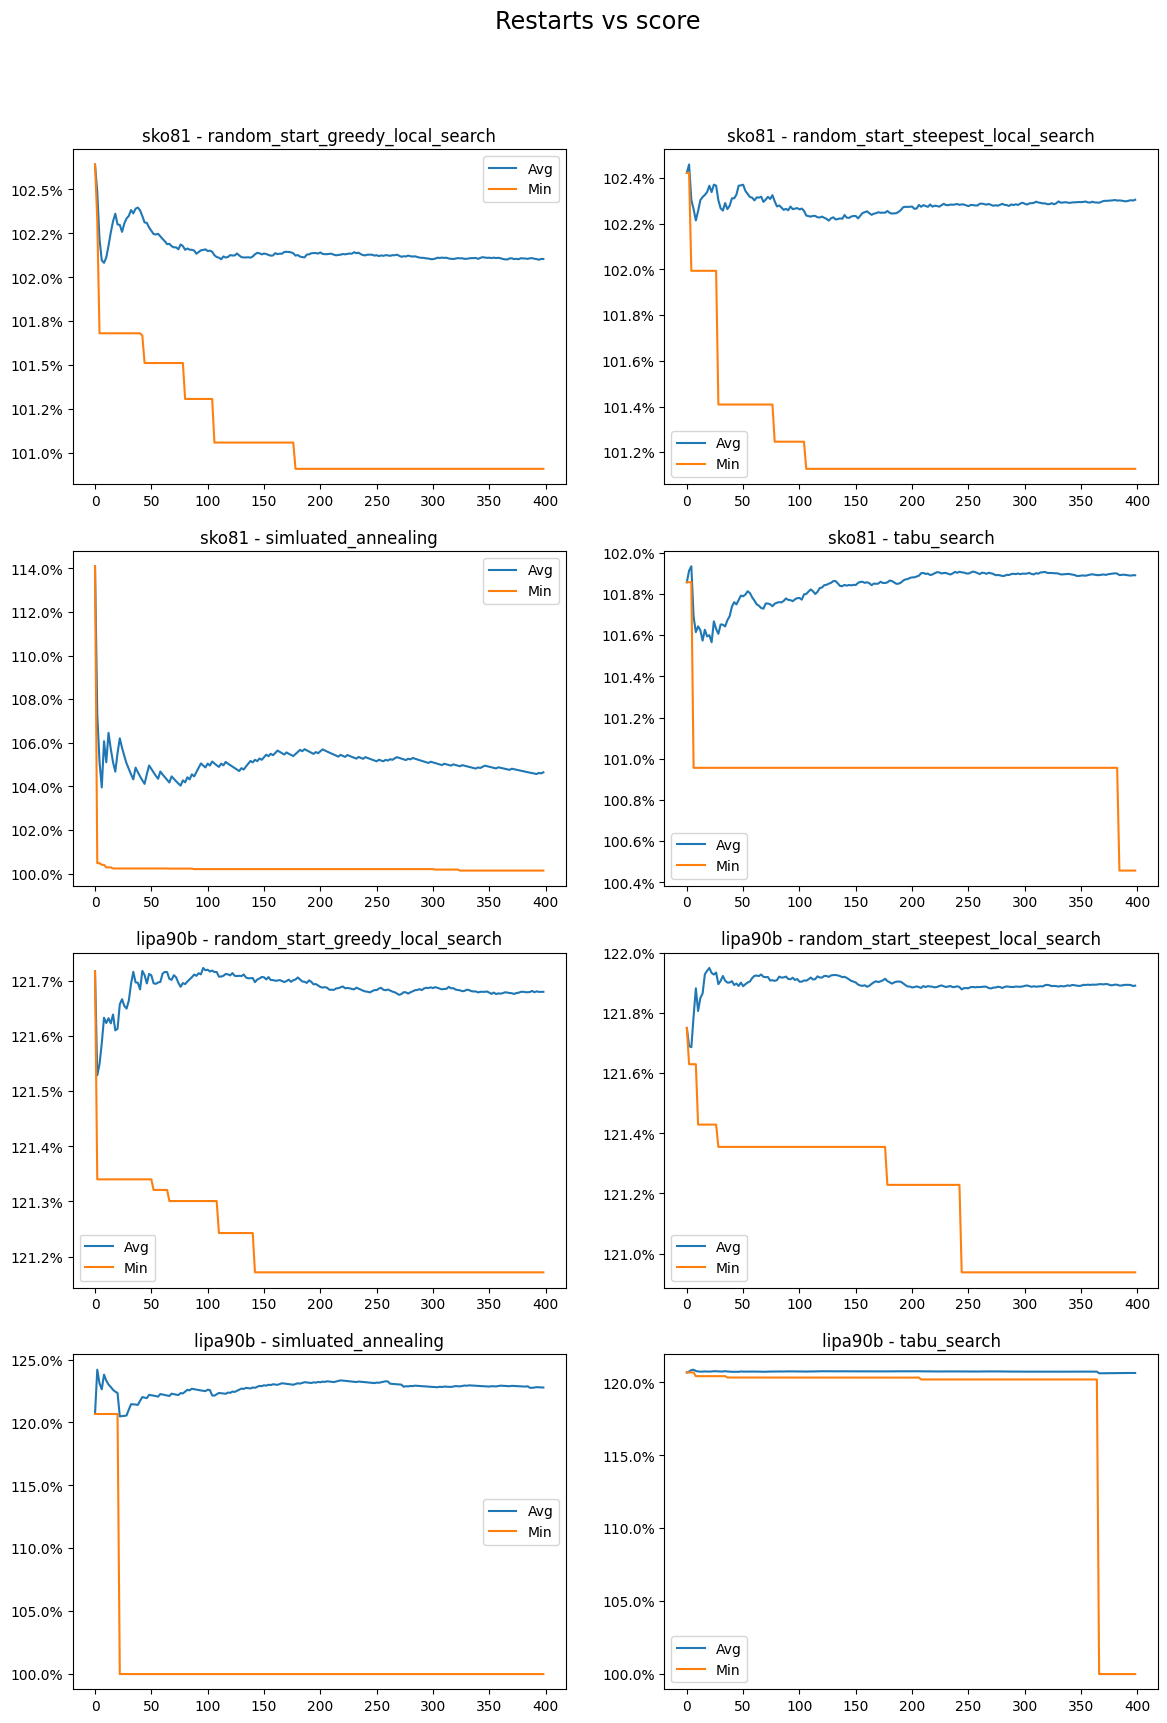

In [15]:
fig = plt.figure(figsize=(14, 20))
st = fig.suptitle("Restarts vs score", fontsize="xx-large")

for i, instance in enumerate(instances[-2:]):

    for j, algo in enumerate(filter(lambda x: "local_search"  in x or "tabu"  in x or "annealing"  in x, algos)):
        ax = fig.add_subplot(4, 2, i * 4 + j + 1)
        
        y_min= []
        y_avg = []
        y_avg_buffer = []

        for r in instances_data[instance][algo].runs:
            score = r.final_score / instances_data[instance][algo].optimum * 100
            y_avg_buffer.append(score)
            y_avg.append(np.mean(y_avg_buffer))
            y_min.append(np.min(y_avg_buffer))

        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.1f}%"))
        ax.set_title(f"{instance} - {algo}")

        x = np.arange(0, len(y_avg_buffer) * 2, 2)

        ax.plot(x, y_avg, label="Avg")
        ax.plot(x, y_min, label="Min")
        ax.legend()

st.set_y(0.95)
fig.subplots_adjust(top=0.88)

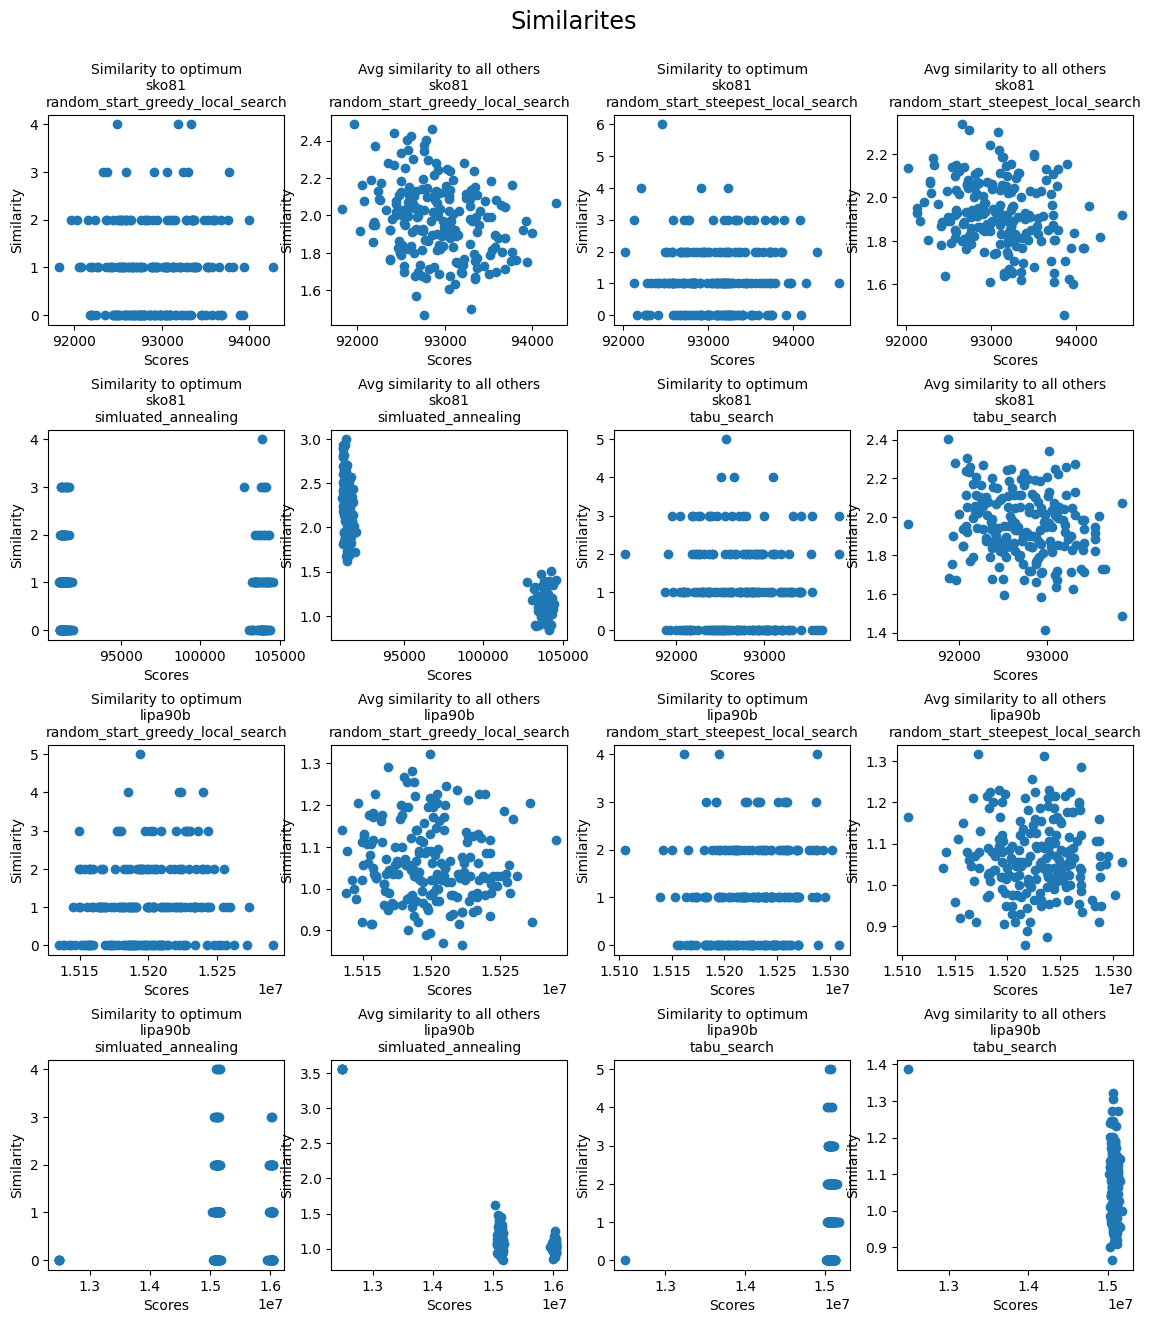

In [34]:
def set_ax_params(c_ax):
    c_ax.set_xlabel("Scores")
    c_ax.set_ylabel("Similarity")

fig = plt.figure(figsize=(14, 15))
st = fig.suptitle("Similarites", fontsize="xx-large")

ax_index = 1

for i, instance in enumerate(instances[-2:]):

    for j, algo in enumerate(filter(lambda x: "local_search"  in x or "tabu"  in x or "annealing"  in x, algos)):

        ax = fig.add_subplot(4, 4, ax_index)
        ax_index += 1
        
        y = []
        x = []

        algo_data = instances_data[instance][algo]

        for bs in algo_data.similarities_best:
            x.append(bs[0])
            y.append(bs[1])

        ax.scatter(x, y)
        ax.set_title(f"Similarity to optimum\n{instance}\n{algo}", size=10)
        set_ax_params(ax)

        ax = fig.add_subplot(4, 4, ax_index)
        ax_index += 1
        
        y = []
        x = []

        for bs in algo_data.similarities_avg:
            x.append(bs[0])
            y.append(bs[1])

        ax.scatter(x, y)
        ax.set_title(f"Avg similarity to all others\n{instance}\n{algo}", size=10)
        set_ax_params(ax)

st.set_y(0.95)
fig.subplots_adjust(top=0.88, hspace=0.5)


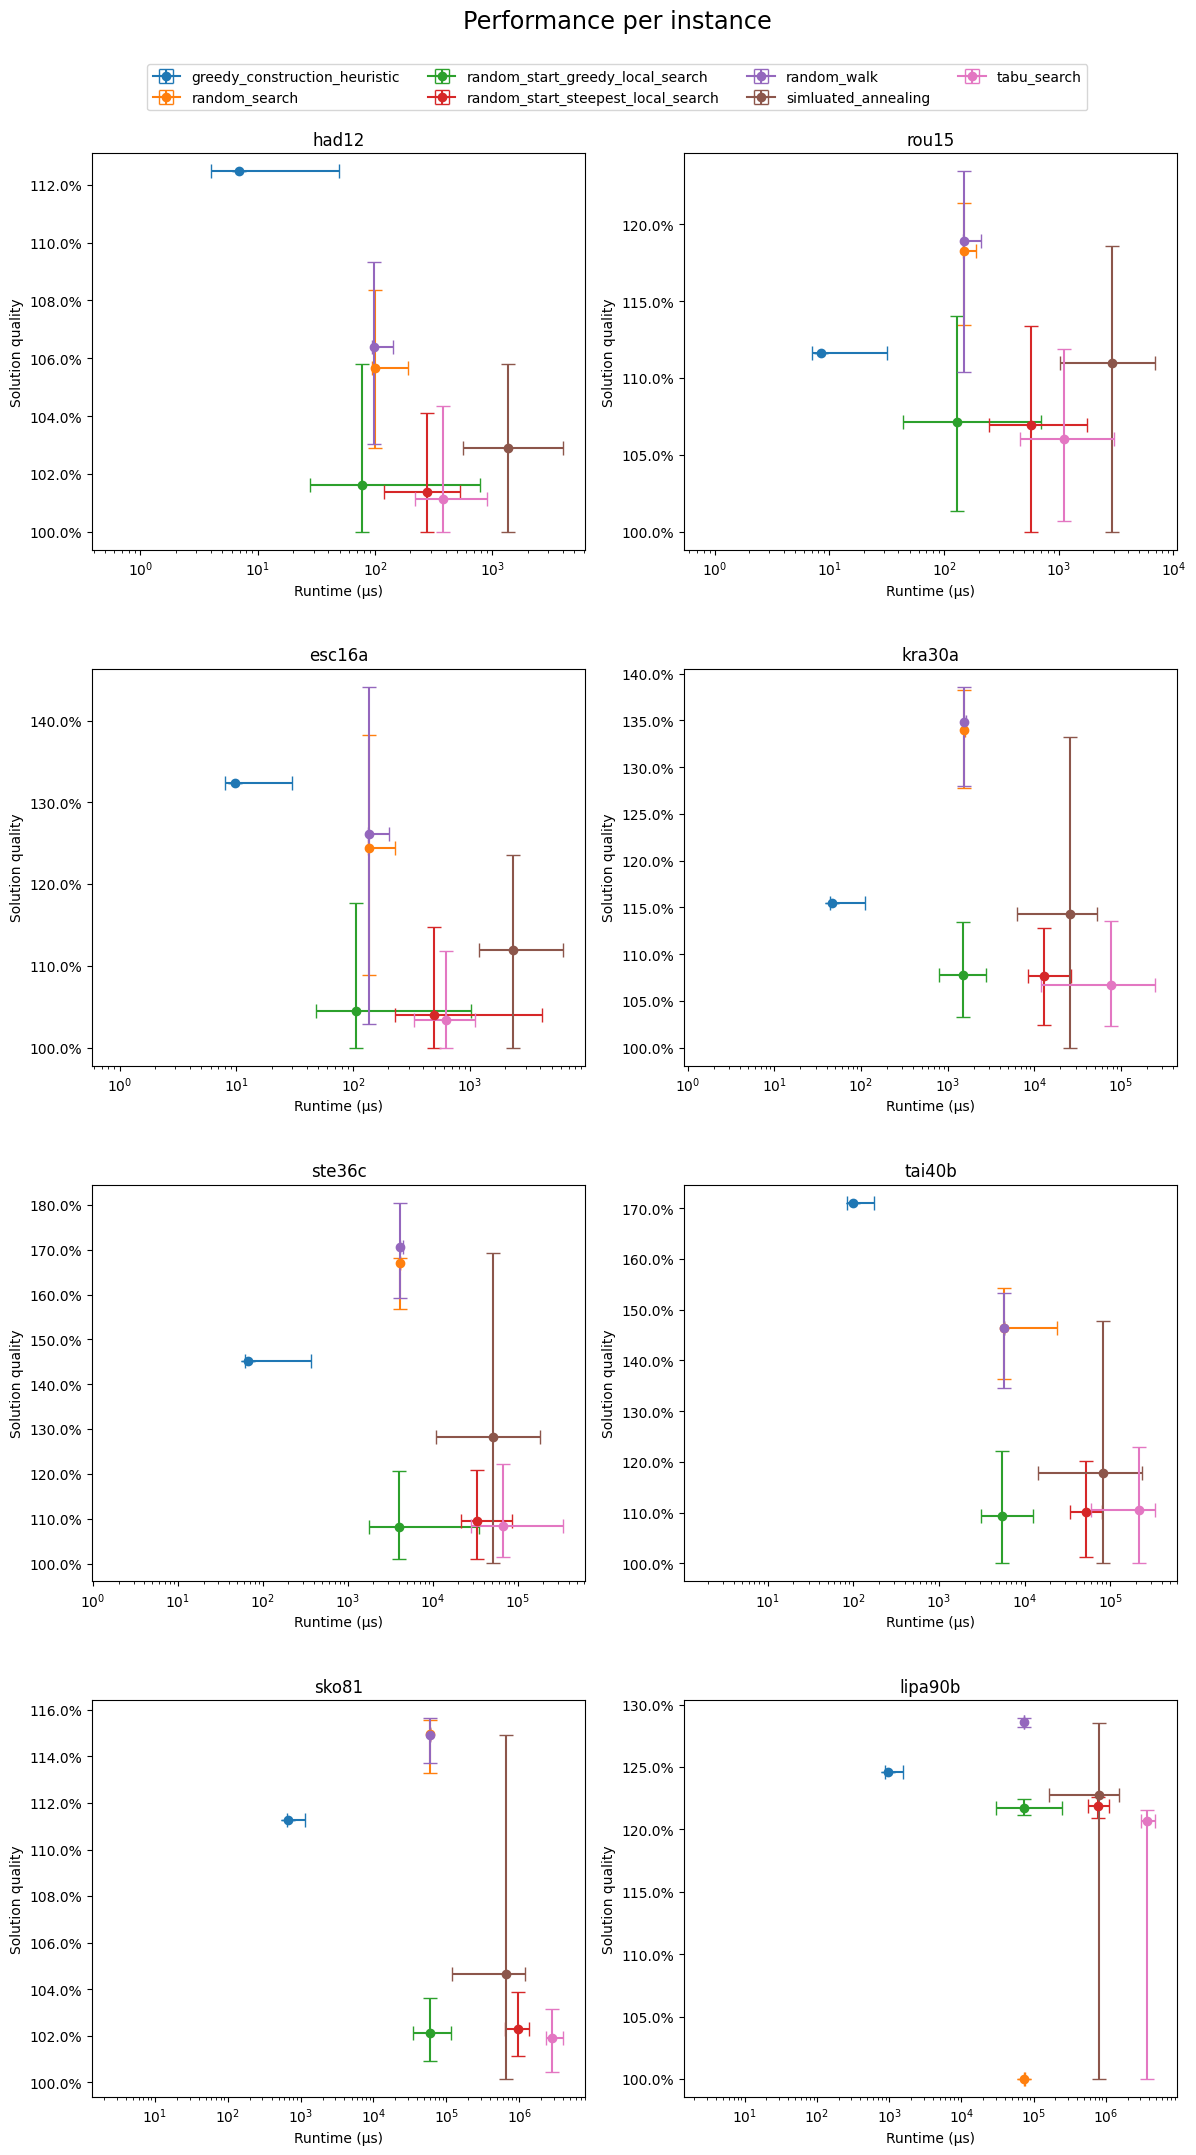

In [10]:
instances_input = instances

fig = plt.figure(figsize=(14, len(instances_input) * 3))
fig.subplots_adjust(hspace=0.3)
st = fig.suptitle("Performance per instance", fontsize="xx-large", y=0.98)

lines = [] 
labels = [] 

for i, instance in enumerate(instances_input):
    ax = fig.add_subplot(math.ceil(len(instances_input) / 2), 2, i + 1)
    ax.set_title(f"{instance}")
    ax.set_ylabel("Solution quality")
    ax.set_xlabel("Runtime (μs)")
    ax.set_xscale("log")

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.1f}%"))
    
    optimum = instances_data[instance][algos[0]].optimum

    for j, algo in enumerate(algos):

        algo_data = instances_data[instance][algo]
        
        y = [
            run.final_score / optimum * 100 for run in instances_data[instance][algo].runs
        ]
        x = [
            run.algorithm_run_time for run in instances_data[instance][algo].runs
        ]
        
        avg_x = np.average(x)
        avg_y = np.average(y)
        max_x = np.abs(np.max(x) - avg_x)
        min_x = np.abs(avg_x - np.min(x))
        max_y = np.abs(np.max(y) - avg_y)
        min_y = np.abs(avg_y - np.min(y))
        
        ax.errorbar(avg_x, avg_y, yerr=([min_y], [max_y]), xerr=([min_x], [max_x]), marker="o", capsize=5, label=f"{algo}")
        
        ax_line, ax_label = ax.get_legend_handles_labels() 
        
        lines= ax_line
        labels= ax_label
        
# st.set_y(0.95)
fig.subplots_adjust(top=0.92)
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), 
           ncol=min(4, len(algos)), frameon=True)